"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [239]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import numpy as np
from scipy.stats import poisson

In [240]:
def var_sig_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-b*x))

def var_sig_exp_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-np.exp(b)*x))


[20, 1]


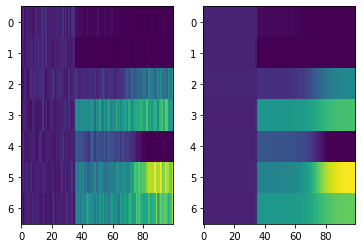

In [411]:
x = np.linspace(-10,10,100)
idx = np.arange(len(x))
states = 3
nrns = 7


#b = [20,1]
b = [20,1]#stats.norm.rvs(0,2, size=states-1)
inflect = [-3,5]
min_val = stats.expon.rvs(10, size=nrns)#3
val_diff = stats.norm.rvs(0,30,size=(nrns,states-1))#[40,-20]

def rate_gen(min_val, diff, inflex, b):
    rate = np.ones(len(x))*min_val
    for this_b, this_diff, this_inflect in zip(b,diff,inflect):
         rate += var_sig_np(x-this_inflect,this_b)*this_diff
    return rate

rate = []
for i in range(nrns):
    this_min = min_val[i]
    this_diff = val_diff[i]
    rate.append(rate_gen(this_min, this_diff, inflect, b))
rate = np.stack(rate)
        
rate[rate<0] = 0
rate+=0.1
data_vec = poisson.rvs(rate)

fig, ax = plt.subplots(1,2)
ax[0].imshow(data_vec,aspect='auto', interpolation='nearest');
ax[1].imshow(rate,aspect='auto', interpolation='nearest');
print(b)

In [412]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-tt.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))


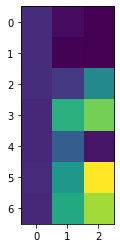

In [413]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)]).T
#print(mean_vals)
plt.imshow(mean_vals);
plt.show()

In [414]:
#from itertools import accumulate as acc
#lambda_test_vals = np.array(list(acc(mean_vals, np.subtract)))
lambda_test_vals = np.diff(mean_vals, axis=-1)
lambda_test_vals

array([[ -8.79055258,  -3.03030303],
       [-11.42691622,  -0.36363636],
       [  3.40017825,  28.24242424],
       [ 48.76916221,  14.87878788],
       [ 17.61675579, -22.42424242],
       [ 38.73351159,  43.45454545],
       [ 45.75311943,  23.90909091]])

In [415]:
even_switches = np.linspace(0,1,states+1)[1:-1]
even_switches

array([0.33333333, 0.66666667])

In [416]:

with pm.Model() as model:
      
    sig_b = pm.Normal('sig_b', -1,2, shape = states-1)
    #sig_b = pm.HalfCauchy('sig_b', 2, testval = 0.1)
    
    # Finite, but somewhere on the lower end, Beta prior
    
    s0 = pm.Exponential('state0', 
                        1/(np.mean(mean_vals)),
                        shape = nrns,
                        testval = mean_vals[:,0])
    
    lambda_diff = pm.Normal('lambda_diff', 
                            mu = 0, sigma = 10, 
                            shape = (nrns,states-1), 
                            testval = lambda_test_vals)#,
                                  #testval = mean_vals + 1e-3)

                        
                        
    a = pm.HalfCauchy('a_tau', 10, shape = states - 1)
    b = pm.HalfCauchy('b_tau', 10, shape = states - 1)
    
    #tau_latent = pm.Beta('tau_latent', 2, 5, 
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [417]:
with model:
    weight1 = var_sig_exp_tt(idx-tau[0],sig_b[0])
    weight2 = var_sig_exp_tt(idx-tau[1],sig_b[1])
    weight_stack = tt.stack([weight1,weight2])
    weight_stack_temp = tt.tile(weight_stack[None,:,:],(nrns,1,1))
weight_stack_temp.tag.test_value.shape

(7, 2, 100)

In [418]:
with model:
    s0_temp = tt.tile(s0[:,None,None], (1,states-1, len(idx)))
s0_temp.tag.test_value.shape

(7, 2, 100)

In [419]:
with model:
    lambda_diff_temp = tt.tile(lambda_diff[:,:,None], (1,1, len(idx)))
lambda_diff_temp.tag.test_value.shape

(7, 2, 100)

In [420]:
with model:
    
    lambda_ =  pm.Deterministic('lambda_',
                    tt.sum(s0_temp + (weight_stack_temp*lambda_diff_temp),axis=1))
    lambda_bounded = pm.Deterministic("lambda_bounded", tt.switch(lambda_>=0, lambda_, 0))
    
    #     weight_stack = var_sig_exp_tt(idx[np.newaxis,:]-tau[:,np.newaxis],sig_b)
    #     #weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    #     weight_stack = tt.concatenate([np.ones((1,fin_length)),weight_stack],axis=0)
    #     inverse_stack = 1 - weight_stack[1:]
    #     inverse_stack = tt.concatenate([inverse_stack, np.ones((1,fin_length))],axis=0)
    #     weight_stack = np.multiply(weight_stack,inverse_stack)
    # lambda_ = pm.math.sum(np.multiply(weight_stack,lambda_latent[:,np.newaxis]),axis=0)

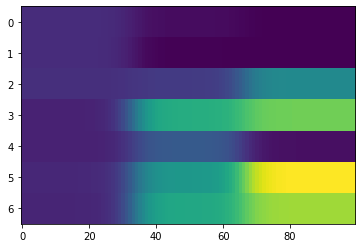

In [421]:
plt.imshow(lambda_bounded.tag.test_value,aspect='auto', interpolation='nearest');

In [422]:
# plt.imshow(weight_stack.tag.test_value,aspect='auto')

In [423]:
with model:
    # Add observations
    observation = pm.Poisson("obs", lambda_bounded, observed=data_vec)

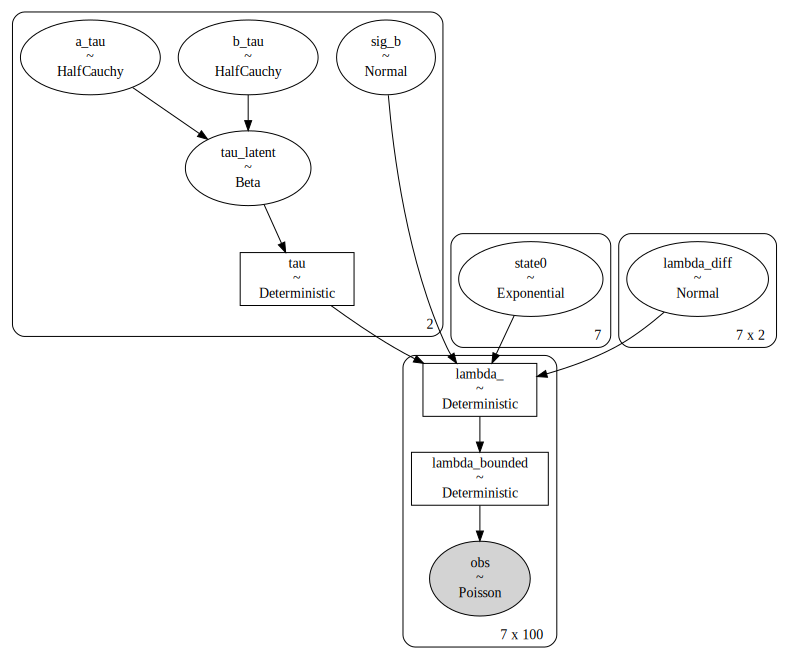

In [424]:
pm.model_to_graphviz(model)

In [438]:
fit = 40000
samples = 10000
with model:
    #     inference = pm.ADVI('full-rank')
    #     #     tracker = pm.callbacks.Tracker(
    #     #             mean=inference.approx.mean.eval,  # callable that returns mean
    #     #             std=inference.approx.std.eval,  # callable that returns std
    #     #         )
    #     approx = pm.fit(n=fit, method=inference)#,
    #     #                    callbacks=[tracker])
    #     trace = approx.sample(draws=samples)
    full_trace = pm.sample(draws=samples)
    trace = full_trace[::10]

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda_diff, state0, sig_b]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 165 seconds.
There were 9441 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9406 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8856 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9438 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/plots/plot_utils.py:496: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (5724) in plot_autocorr, generating only 40 plots
  UserWarning,


array([[<AxesSubplot:title={'center':'sig_b\n0, 0'}>,
        <AxesSubplot:title={'center':'sig_b\n0, 1'}>,
        <AxesSubplot:title={'center':'sig_b\n1, 0'}>,
        <AxesSubplot:title={'center':'sig_b\n1, 1'}>],
       [<AxesSubplot:title={'center':'sig_b\n2, 0'}>,
        <AxesSubplot:title={'center':'sig_b\n2, 1'}>,
        <AxesSubplot:title={'center':'sig_b\n3, 0'}>,
        <AxesSubplot:title={'center':'sig_b\n3, 1'}>],
       [<AxesSubplot:title={'center':'lambda_diff\n0, 0, 0'}>,
        <AxesSubplot:title={'center':'lambda_diff\n0, 0, 1'}>,
        <AxesSubplot:title={'center':'lambda_diff\n0, 1, 0'}>,
        <AxesSubplot:title={'center':'lambda_diff\n0, 1, 1'}>],
       [<AxesSubplot:title={'center':'lambda_diff\n0, 2, 0'}>,
        <AxesSubplot:title={'center':'lambda_diff\n0, 2, 1'}>,
        <AxesSubplot:title={'center':'lambda_diff\n0, 3, 0'}>,
        <AxesSubplot:title={'center':'lambda_diff\n0, 3, 1'}>],
       [<AxesSubplot:title={'center':'lambda_diff\n0, 4, 0'}

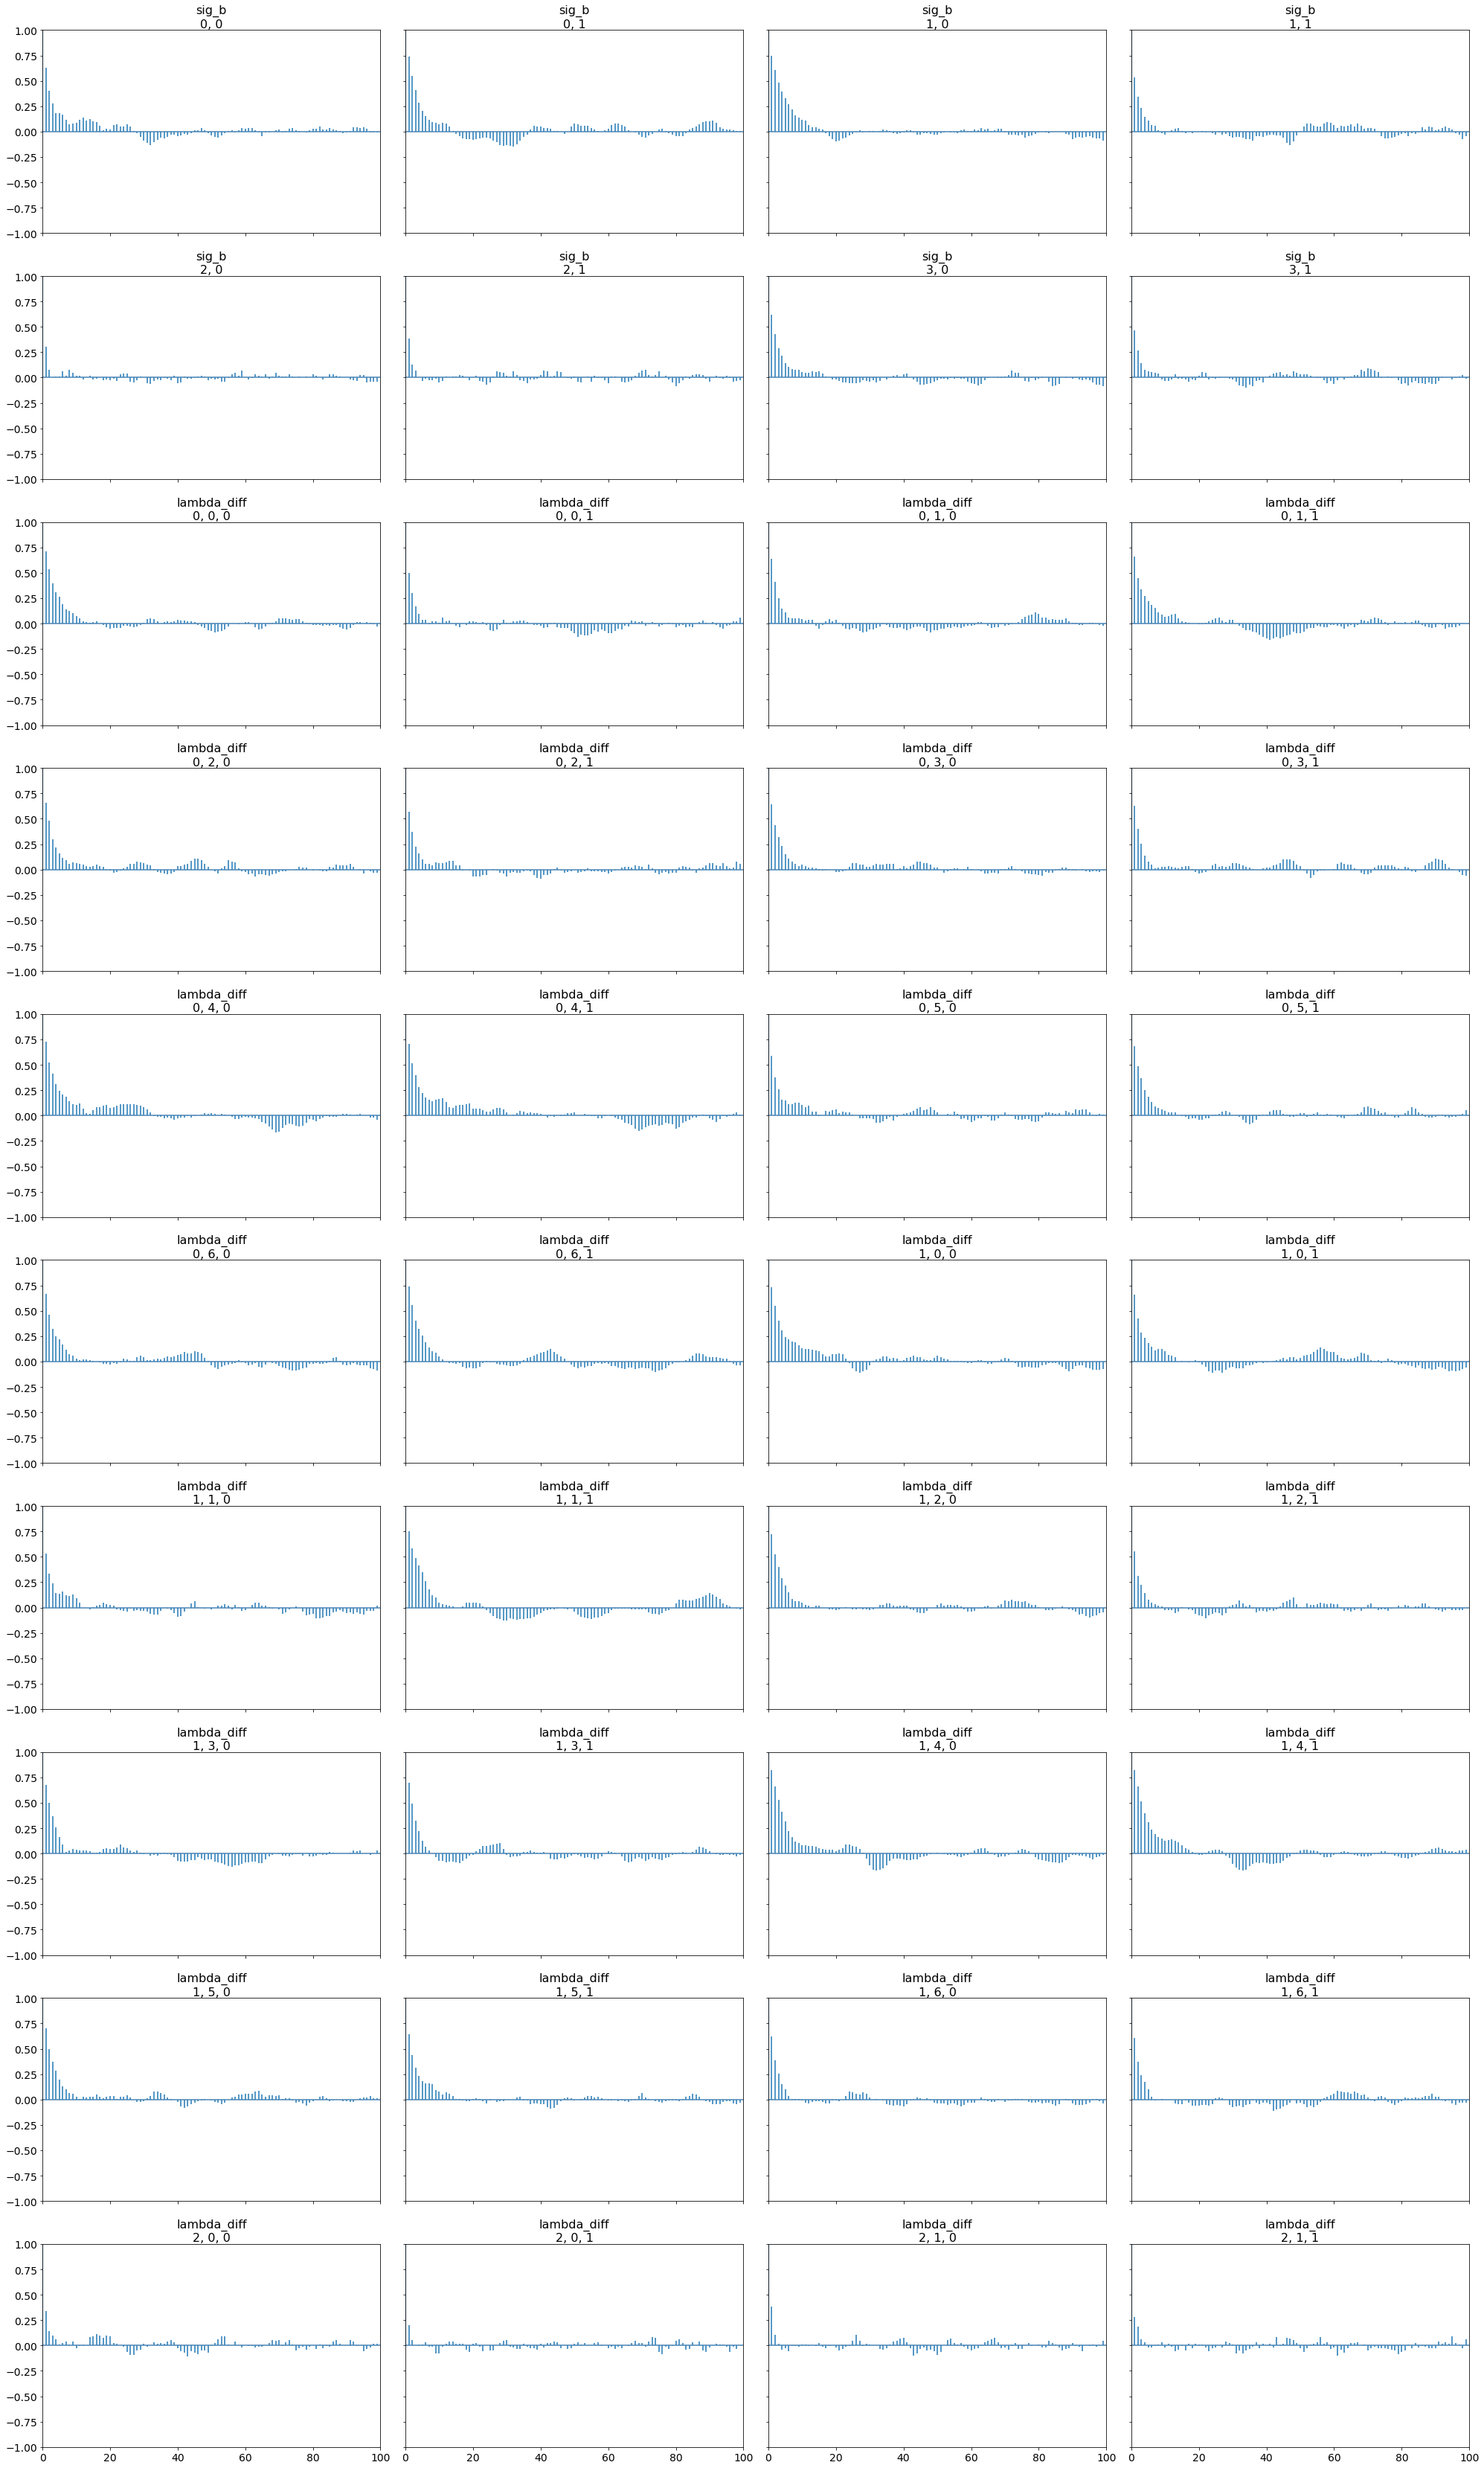

In [439]:
pm.autocorrplot(trace)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/plots/__init__.py:36: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  f"Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8"


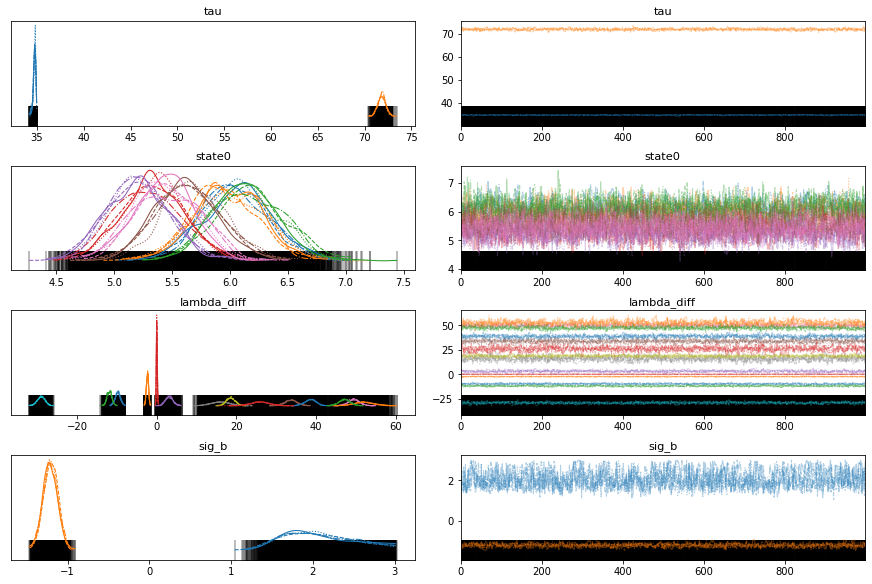

In [440]:
with model:
    pm.traceplot(trace, varnames = ['tau', 'state0', 'lambda_diff', 'sig_b'])

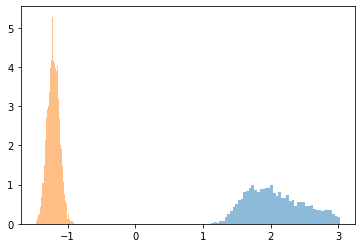

In [441]:
for x in trace['sig_b'].T:
    plt.hist(x,50, alpha=0.5, density=True);
#np.mean(trace['sig_b'])

In [428]:
np.power(10,np.mean(trace['sig_b'],axis=0))

array([1.13369861e+02, 6.23525446e-02])

In [429]:
np.power(10,np.diff(np.mean(trace['sig_b'],axis=0)))

array([0.00054999])

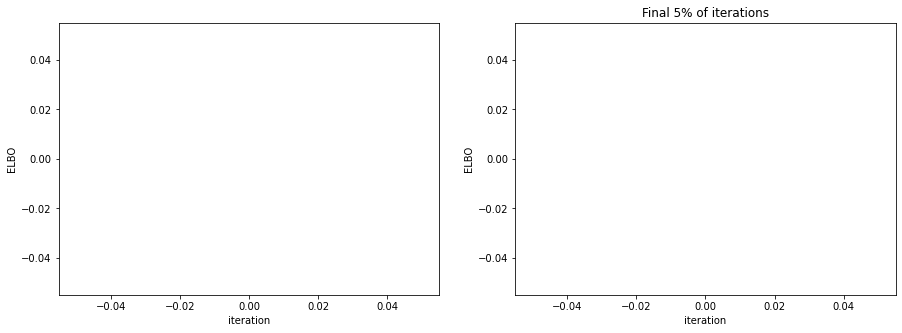

In [430]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [431]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [432]:
# fig,ax = plt.subplots(1,2,sharey=True)
# ax[0].plot(rate)
# ax[1].plot(np.mean(ppc['obs'],axis=0), alpha=1)
# ax[0].set_title('True r')
# ax[1].set_title('Mean prediction')

In [433]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

(8000, 2)


array([34, 71])

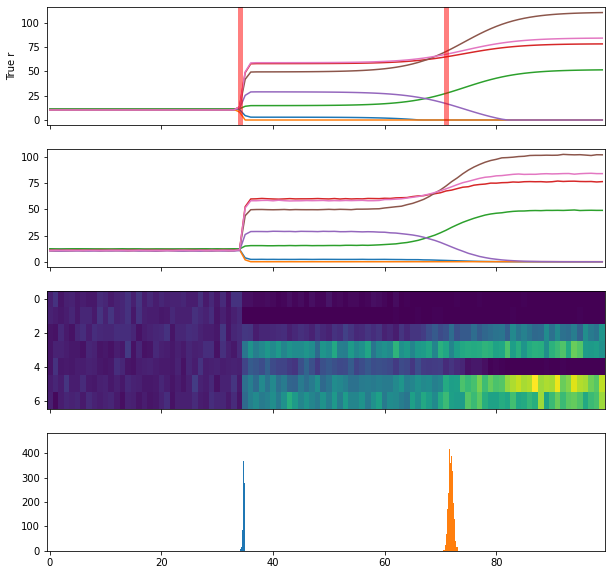

In [434]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(10,10))
#ax[0].imshow(rate, interpolation='nearest', aspect='auto')
ax[0].plot(rate.T)
ax[0].set_ylabel('True r')
#ax[1].imshow(np.mean(ppc['obs'],axis=0), interpolation='nearest', aspect='auto')
ax[1].plot(np.mean(ppc['obs'],axis=0).T)
ax[2].imshow(data_vec, interpolation='nearest', aspect='auto')
    
for tau_num, this_tau in enumerate(tau.T):
    ax[3].hist(this_tau,bins=50)
    ax[0].axvline(mode_tau[tau_num],color='red',alpha=0.5,linewidth=5)
